In [10]:
# Check CUDA availability and setup
import torch
import torch.nn.functional as F
from torch.utils.cpp_extension import load
import numpy as np
import time
import matplotlib.pyplot as plt

print("🔍 Checking CUDA Environment...")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name()}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("❌ CUDA not available! Please enable GPU runtime in Colab.")
    print("Go to Runtime -> Change runtime type -> Hardware accelerator -> GPU")

🔍 Checking CUDA Environment...
CUDA available: True
Device: Tesla T4
CUDA version: 12.4
GPU memory: 15.8 GB


In [11]:
%%writefile softmax.cu
#include <torch/extension.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <device_launch_parameters.h>
#include <cfloat>

// CUDA kernel for row-wise softmax
__global__ void softmax_cuda_kernel(
    const float* __restrict__ input,
    float* __restrict__ output,
    int rows,
    int cols) {

    int row = blockIdx.x * blockDim.x + threadIdx.x;

    if (row >= rows) return;

    const float* input_row = input + row * cols;
    float* output_row = output + row * cols;

    // Step 1: Find maximum value in the row for numerical stability
    float max_val = -FLT_MAX;
    for (int col = 0; col < cols; col++) {
        max_val = fmaxf(max_val, input_row[col]);
    }

    // Step 2: Compute exp(x - max) and sum
    float sum_exp = 0.0f;
    for (int col = 0; col < cols; col++) {
        float exp_val = expf(input_row[col] - max_val);
        output_row[col] = exp_val;
        sum_exp += exp_val;
    }

    // Step 3: Normalize by sum to get softmax
    for (int col = 0; col < cols; col++) {
        output_row[col] /= sum_exp;
    }
}

// Optimized version using shared memory for larger matrices
__global__ void softmax_cuda_kernel_optimized(
    const float* __restrict__ input,
    float* __restrict__ output,
    int rows,
    int cols) {

    int row = blockIdx.x;
    int tid = threadIdx.x;
    int threads_per_block = blockDim.x;

    if (row >= rows) return;

    extern __shared__ float sdata[];

    const float* input_row = input + row * cols;
    float* output_row = output + row * cols;

    // Step 1: Find row maximum using block reduction
    float thread_max = -FLT_MAX;
    for (int i = tid; i < cols; i += threads_per_block) {
        thread_max = fmaxf(thread_max, input_row[i]);
    }

    sdata[tid] = thread_max;
    __syncthreads();

    // Reduction to find global maximum
    for (int s = threads_per_block / 2; s > 0; s >>= 1) {
        if (tid < s) {
            sdata[tid] = fmaxf(sdata[tid], sdata[tid + s]);
        }
        __syncthreads();
    }

    float row_max = sdata[0];
    __syncthreads();

    // Step 2: Compute exp values and sum
    float thread_sum = 0.0f;
    for (int i = tid; i < cols; i += threads_per_block) {
        float exp_val = expf(input_row[i] - row_max);
        output_row[i] = exp_val;
        thread_sum += exp_val;
    }

    sdata[tid] = thread_sum;
    __syncthreads();

    // Reduction to find global sum
    for (int s = threads_per_block / 2; s > 0; s >>= 1) {
        if (tid < s) {
            sdata[tid] += sdata[tid + s];
        }
        __syncthreads();
    }

    float row_sum = sdata[0];
    __syncthreads();

    // Step 3: Normalize
    for (int i = tid; i < cols; i += threads_per_block) {
        output_row[i] /= row_sum;
    }
}

// Host function to launch CUDA kernel
torch::Tensor softmax_cuda(torch::Tensor input) {
    // Check input tensor properties
    TORCH_CHECK(input.type().is_cuda(), "Input tensor must be on CUDA device");
    TORCH_CHECK(input.dtype() == torch::kFloat32, "Input tensor must be float32");
    TORCH_CHECK(input.dim() == 2, "Input tensor must be 2D");

    const int rows = input.size(0);
    const int cols = input.size(1);

    // Create output tensor
    auto output = torch::zeros_like(input);

    // Choose kernel based on problem size
    if (cols <= 1024) {
        // Simple kernel for smaller matrices
        const int threads_per_block = 256;
        const int blocks = (rows + threads_per_block - 1) / threads_per_block;

        softmax_cuda_kernel<<<blocks, threads_per_block>>>(
            input.data_ptr<float>(),
            output.data_ptr<float>(),
            rows,
            cols
        );
    } else {
        // Optimized kernel for larger matrices
        const int threads_per_block = 256;
        const int blocks = rows;
        const size_t shared_mem_size = threads_per_block * sizeof(float);

        softmax_cuda_kernel_optimized<<<blocks, threads_per_block, shared_mem_size>>>(
            input.data_ptr<float>(),
            output.data_ptr<float>(),
            rows,
            cols
        );
    }

    // Check for CUDA errors
    cudaError_t err = cudaGetLastError();
    TORCH_CHECK(err == cudaSuccess, "CUDA kernel launch failed: ", cudaGetErrorString(err));

    return output;
}

// PyBind11 module definition
PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
    m.def("softmax_cuda", &softmax_cuda, "Custom CUDA softmax implementation");
}

Overwriting softmax.cu


In [12]:
print("🔨 Compiling CUDA extension...")
print("This may take 1-2 minutes on first run...")

# Compile the extension
softmax_cuda = load(
    name="softmax_cuda",
    sources=["softmax.cu"],
    extra_cuda_cflags=["-O3", "--use_fast_math"],
    verbose=True
)

print("✅ Compilation successful!")

🔨 Compiling CUDA extension...
This may take 1-2 minutes on first run...


Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py311_cu124/softmax_cuda...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu124/softmax_cuda/build.ninja...
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module softmax_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


✅ Compilation successful!


Loading extension module softmax_cuda...


In [13]:
def test_basic_correctness():
    print("🧪 Testing basic correctness...")

    # Create test data
    rows, cols = 100, 200
    device = torch.device('cuda')
    input_tensor = torch.randn(rows, cols, device=device, dtype=torch.float32)

    # Compute softmax using our custom kernel
    custom_output = softmax_cuda.softmax_cuda(input_tensor)

    # Compute softmax using PyTorch
    torch_output = F.softmax(input_tensor, dim=1)

    # Check differences
    max_diff = torch.max(torch.abs(custom_output - torch_output)).item()
    mean_diff = torch.mean(torch.abs(custom_output - torch_output)).item()

    # Check softmax properties
    row_sums = torch.sum(custom_output, dim=1)
    sum_error = torch.max(torch.abs(row_sums - 1.0)).item()

    print(f"Max difference: {max_diff:.2e}")
    print(f"Mean difference: {mean_diff:.2e}")
    print(f"Row sum error: {sum_error:.2e}")

    # Check for numerical issues
    has_nan = torch.any(torch.isnan(custom_output))
    has_inf = torch.any(torch.isinf(custom_output))

    print(f"Has NaN: {has_nan}")
    print(f"Has Inf: {has_inf}")

    if max_diff < 1e-5 and sum_error < 1e-5 and not has_nan and not has_inf:
        print("✅ Basic correctness test PASSED!")
        return True
    else:
        print("❌ Basic correctness test FAILED!")
        return False

# Run the test
test_basic_correctness()

🧪 Testing basic correctness...
Max difference: 3.73e-08
Mean difference: 8.79e-10
Row sum error: 4.77e-07
Has NaN: False
Has Inf: False
✅ Basic correctness test PASSED!


True

In [14]:
def comprehensive_correctness_tests():
    print("🔬 Running comprehensive correctness tests...")

    test_cases = [
        (32, 128, "Small matrix"),
        (256, 512, "Medium matrix"),
        (1024, 1024, "Large square matrix"),
        (10, 10000, "Wide matrix"),
        (10000, 10, "Tall matrix"),
        (1, 1000, "Single row"),
        (1000, 1, "Single column"),
    ]

    all_passed = True

    for rows, cols, description in test_cases:
        print(f"\n📋 Testing {description} ({rows}x{cols}):")

        # Create test data
        input_tensor = torch.randn(rows, cols, device='cuda', dtype=torch.float32)

        # Test with large values for numerical stability
        if "numerical" not in description:
            input_tensor = input_tensor * 10  # Scale up for stability test

        try:
            # Custom softmax
            custom_output = softmax_cuda.softmax_cuda(input_tensor)

            # PyTorch softmax
            torch_output = F.softmax(input_tensor, dim=1)

            # Compute metrics
            max_diff = torch.max(torch.abs(custom_output - torch_output)).item()
            row_sums = torch.sum(custom_output, dim=1)
            sum_error = torch.max(torch.abs(row_sums - 1.0)).item()

            has_nan = torch.any(torch.isnan(custom_output))
            has_inf = torch.any(torch.isinf(custom_output))

            print(f"  Max difference: {max_diff:.2e}")
            print(f"  Sum error: {sum_error:.2e}")

            # Test criteria
            tolerance = 1e-4
            passed = (max_diff < tolerance and sum_error < tolerance and
                     not has_nan and not has_inf)

            if passed:
                print("  ✅ PASSED")
            else:
                print("  ❌ FAILED")
                all_passed = False

        except Exception as e:
            print(f"  ❌ ERROR: {e}")
            all_passed = False

    if all_passed:
        print("\n🎉 All correctness tests PASSED!")
    else:
        print("\n⚠️  Some tests FAILED!")

    return all_passed

# Run comprehensive tests
comprehensive_correctness_tests()

🔬 Running comprehensive correctness tests...

📋 Testing Small matrix (32x128):
  Max difference: 5.96e-07
  Sum error: 4.77e-07
  ✅ PASSED

📋 Testing Medium matrix (256x512):
  Max difference: 7.75e-07
  Sum error: 9.54e-07
  ✅ PASSED

📋 Testing Large square matrix (1024x1024):
  Max difference: 1.01e-06
  Sum error: 1.19e-06
  ✅ PASSED

📋 Testing Wide matrix (10x10000):
  Max difference: 5.96e-08
  Sum error: 1.19e-07
  ✅ PASSED

📋 Testing Tall matrix (10000x10):
  Max difference: 2.98e-07
  Sum error: 3.58e-07
  ✅ PASSED

📋 Testing Single row (1x1000):
  Max difference: 1.86e-09
  Sum error: 0.00e+00
  ✅ PASSED

📋 Testing Single column (1000x1):
  Max difference: 0.00e+00
  Sum error: 0.00e+00
  ✅ PASSED

🎉 All correctness tests PASSED!


True

In [15]:
def benchmark_performance():
    print("⚡ Running performance benchmark...")

    test_shapes = [
        (512, 512),
        (1024, 1024),
        (2048, 1024),
        (1024, 2048),
        (4096, 512),
        (512, 4096),
    ]

    num_runs = 100
    warmup_runs = 10

    print(f"\nRunning {num_runs} iterations with {warmup_runs} warmup runs")
    print(f"{'Shape':<12} {'Custom (ms)':<12} {'PyTorch (ms)':<13} {'Speedup':<10}")
    print("-" * 50)

    results = []

    for rows, cols in test_shapes:
        # Create test data
        input_tensor = torch.randn(rows, cols, device='cuda', dtype=torch.float32)

        # Warmup
        for _ in range(warmup_runs):
            _ = softmax_cuda.softmax_cuda(input_tensor)
            _ = F.softmax(input_tensor, dim=1)

        torch.cuda.synchronize()

        # Benchmark custom kernel
        start_time = time.time()
        for _ in range(num_runs):
            _ = softmax_cuda.softmax_cuda(input_tensor)
        torch.cuda.synchronize()
        custom_time = (time.time() - start_time) * 1000 / num_runs

        # Benchmark PyTorch
        start_time = time.time()
        for _ in range(num_runs):
            _ = F.softmax(input_tensor, dim=1)
        torch.cuda.synchronize()
        pytorch_time = (time.time() - start_time) * 1000 / num_runs

        speedup = pytorch_time / custom_time

        shape_str = f"{rows}x{cols}"
        print(f"{shape_str:<12} {custom_time:<12.3f} {pytorch_time:<13.3f} {speedup:<10.2f}x")

        results.append((shape_str, custom_time, pytorch_time, speedup))

    # Summary
    speedups = [r[3] for r in results]
    avg_speedup = np.mean(speedups)

    print(f"\n📊 Average speedup: {avg_speedup:.2f}x")

    if avg_speedup > 1.0:
        print("🚀 Custom kernel is faster on average!")
    else:
        print("🐌 PyTorch is faster on average.")
        print("   (This is normal - PyTorch uses highly optimized cuBLAS/cuDNN)")

    return results

# Run benchmark
benchmark_results = benchmark_performance()

⚡ Running performance benchmark...

Running 100 iterations with 10 warmup runs
Shape        Custom (ms)  PyTorch (ms)  Speedup   
--------------------------------------------------
512x512      1.437        0.009         0.01      x
1024x1024    1.666        0.041         0.02      x
2048x1024    1.136        0.079         0.07      x
1024x2048    0.111        0.078         0.70      x
4096x512     0.636        0.078         0.12      x
512x4096     0.130        0.074         0.57      x

📊 Average speedup: 0.25x
🐌 PyTorch is faster on average.
   (This is normal - PyTorch uses highly optimized cuBLAS/cuDNN)


📈 Creating performance visualization...


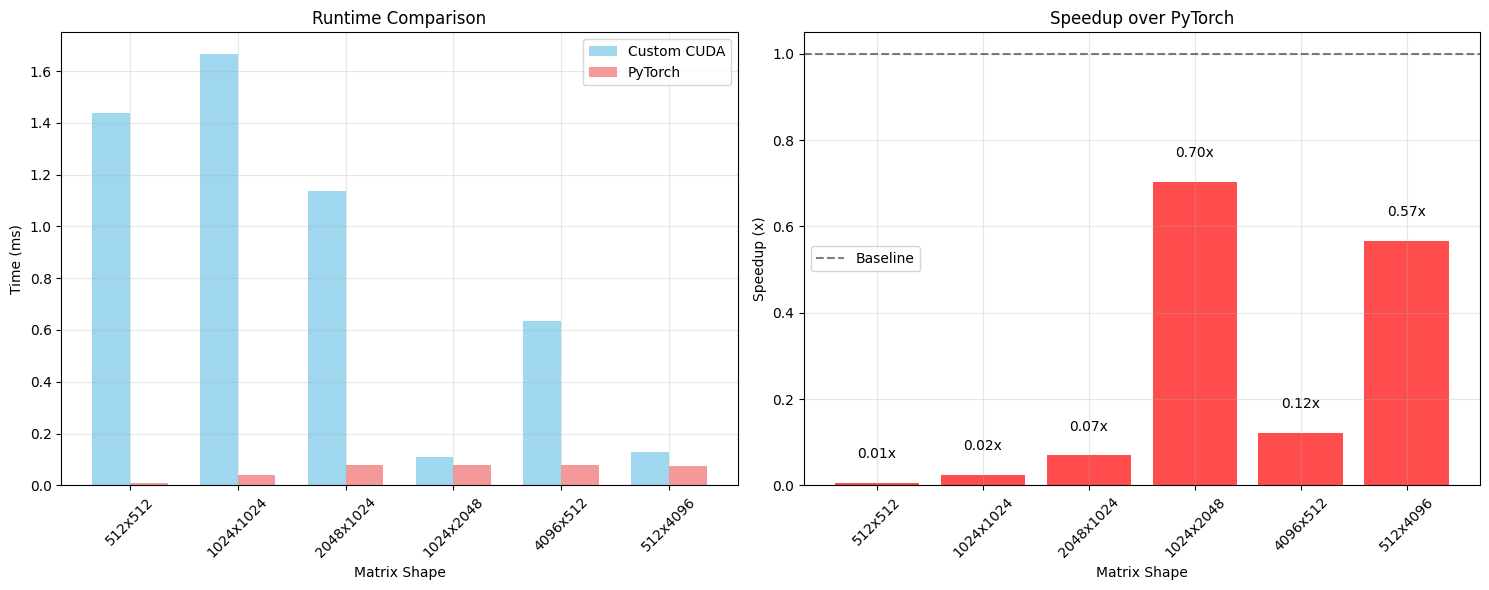

📊 Performance visualization complete!


In [16]:
def plot_benchmark_results(results):
    print("📈 Creating performance visualization...")

    # Extract data
    shapes = [r[0] for r in results]
    custom_times = [r[1] for r in results]
    pytorch_times = [r[2] for r in results]
    speedups = [r[3] for r in results]

    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Runtime comparison
    x_pos = np.arange(len(shapes))
    width = 0.35

    ax1.bar(x_pos - width/2, custom_times, width, label='Custom CUDA', alpha=0.8, color='skyblue')
    ax1.bar(x_pos + width/2, pytorch_times, width, label='PyTorch', alpha=0.8, color='lightcoral')

    ax1.set_xlabel('Matrix Shape')
    ax1.set_ylabel('Time (ms)')
    ax1.set_title('Runtime Comparison')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(shapes, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Speedup chart
    colors = ['green' if s >= 1.0 else 'red' for s in speedups]
    bars = ax2.bar(x_pos, speedups, color=colors, alpha=0.7)
    ax2.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Baseline')

    ax2.set_xlabel('Matrix Shape')
    ax2.set_ylabel('Speedup (x)')
    ax2.set_title('Speedup over PyTorch')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(shapes, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Add value labels on speedup bars
    for i, (bar, speedup) in enumerate(zip(bars, speedups)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{speedup:.2f}x', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    print("📊 Performance visualization complete!")

# Create visualization
plot_benchmark_results(benchmark_results)

In [17]:
def analyze_memory_usage():
    print("💾 Analyzing memory usage patterns...")

    shapes = [(256, 256), (512, 512), (1024, 1024), (2048, 2048)]

    print(f"{'Shape':<12} {'Input (MB)':<10} {'Output (MB)':<11} {'Total (MB)':<10}")
    print("-" * 45)

    for rows, cols in shapes:
        input_size_mb = (rows * cols * 4) / (1024 * 1024)  # 4 bytes per float32
        output_size_mb = input_size_mb  # Same size as input
        total_mb = input_size_mb + output_size_mb

        shape_str = f"{rows}x{cols}"
        print(f"{shape_str:<12} {input_size_mb:<10.2f} {output_size_mb:<11.2f} {total_mb:<10.2f}")

        # Test actual memory allocation
        try:
            input_tensor = torch.randn(rows, cols, device='cuda', dtype=torch.float32)

            # Check GPU memory before
            torch.cuda.empty_cache()
            mem_before = torch.cuda.memory_allocated() / (1024 * 1024)

            # Run our kernel
            output = softmax_cuda.softmax_cuda(input_tensor)

            # Check GPU memory after
            mem_after = torch.cuda.memory_allocated() / (1024 * 1024)
            mem_used = mem_after - mem_before

            print(f"  Actual GPU memory used: {mem_used:.2f} MB")

            # Clean up
            del input_tensor, output
            torch.cuda.empty_cache()

        except RuntimeError as e:
            print(f"  ⚠️  Memory error for {shape_str}: {e}")

analyze_memory_usage()

💾 Analyzing memory usage patterns...
Shape        Input (MB) Output (MB) Total (MB)
---------------------------------------------
256x256      0.25       0.25        0.50      
  Actual GPU memory used: 0.25 MB
512x512      1.00       1.00        2.00      
  Actual GPU memory used: 1.00 MB
1024x1024    4.00       4.00        8.00      
  Actual GPU memory used: 4.00 MB
2048x2048    16.00      16.00       32.00     
  Actual GPU memory used: 16.00 MB


In [18]:
def test_numerical_stability():
    print("🔢 Testing numerical stability with extreme values...")

    test_cases = [
        ("Large positive values", lambda: torch.randn(100, 100, device='cuda') * 100),
        ("Large negative values", lambda: torch.randn(100, 100, device='cuda') * -100),
        ("Mixed large values", lambda: torch.randn(100, 100, device='cuda') * 1000),
        ("Very small values", lambda: torch.randn(100, 100, device='cuda') * 0.001),
        ("Extreme range", lambda: torch.cat([
            torch.full((50, 100), 1000.0, device='cuda'),
            torch.full((50, 100), -1000.0, device='cuda')
        ], dim=0)),
    ]

    for test_name, tensor_gen in test_cases:
        print(f"\n🧪 {test_name}:")

        try:
            input_tensor = tensor_gen()

            # Our implementation
            custom_output = softmax_cuda.softmax_cuda(input_tensor)

            # PyTorch implementation
            torch_output = F.softmax(input_tensor, dim=1)

            # Check for numerical issues
            custom_nan = torch.any(torch.isnan(custom_output)).item()
            custom_inf = torch.any(torch.isinf(custom_output)).item()
            torch_nan = torch.any(torch.isnan(torch_output)).item()
            torch_inf = torch.any(torch.isinf(torch_output)).item()

            # Check row sums
            custom_sums = torch.sum(custom_output, dim=1)
            custom_sum_error = torch.max(torch.abs(custom_sums - 1.0)).item()

            torch_sums = torch.sum(torch_output, dim=1)
            torch_sum_error = torch.max(torch.abs(torch_sums - 1.0)).item()

            print(f"  Custom - NaN: {custom_nan}, Inf: {custom_inf}, Sum error: {custom_sum_error:.2e}")
            print(f"  PyTorch - NaN: {torch_nan}, Inf: {torch_inf}, Sum error: {torch_sum_error:.2e}")

            if not custom_nan and not custom_inf and custom_sum_error < 1e-4:
                print("  ✅ PASSED")
            else:
                print("  ❌ FAILED")

        except Exception as e:
            print(f"  ❌ ERROR: {e}")

test_numerical_stability()

🔢 Testing numerical stability with extreme values...

🧪 Large positive values:
  Custom - NaN: False, Inf: False, Sum error: 1.19e-07
  PyTorch - NaN: False, Inf: False, Sum error: 1.19e-07
  ✅ PASSED

🧪 Large negative values:
  Custom - NaN: False, Inf: False, Sum error: 1.19e-07
  PyTorch - NaN: False, Inf: False, Sum error: 1.19e-07
  ✅ PASSED

🧪 Mixed large values:
  Custom - NaN: False, Inf: False, Sum error: 5.96e-08
  PyTorch - NaN: False, Inf: False, Sum error: 5.96e-08
  ✅ PASSED

🧪 Very small values:
  Custom - NaN: False, Inf: False, Sum error: 3.58e-07
  PyTorch - NaN: False, Inf: False, Sum error: 1.19e-07
  ✅ PASSED

🧪 Extreme range:
  Custom - NaN: False, Inf: False, Sum error: 0.00e+00
  PyTorch - NaN: False, Inf: False, Sum error: 0.00e+00
  ✅ PASSED


In [19]:
def final_usage_example():
    print("🎯 Final Usage Example")
    print("="*50)

    # Create sample data
    batch_size, seq_length = 64, 512
    logits = torch.randn(batch_size, seq_length, device='cuda', dtype=torch.float32)

    print(f"Input shape: {logits.shape}")
    print(f"Input device: {logits.device}")
    print(f"Input dtype: {logits.dtype}")

    # Apply our custom softmax
    print("\n🚀 Applying custom CUDA softmax...")
    start_time = time.time()
    probabilities = softmax_cuda.softmax_cuda(logits)
    custom_time = (time.time() - start_time) * 1000

    # Apply PyTorch softmax for comparison
    print("🔥 Applying PyTorch softmax...")
    start_time = time.time()
    torch_probabilities = F.softmax(logits, dim=1)
    torch_time = (time.time() - start_time) * 1000

    # Verify results
    max_diff = torch.max(torch.abs(probabilities - torch_probabilities)).item()
    row_sums = torch.sum(probabilities, dim=1)
    sum_error = torch.max(torch.abs(row_sums - 1.0)).item()

    print(f"\n📊 Results:")
    print(f"Custom kernel time: {custom_time:.3f} ms")
    print(f"PyTorch time: {torch_time:.3f} ms")
    print(f"Speedup: {torch_time/custom_time:.2f}x")
    print(f"Max difference: {max_diff:.2e}")
    print(f"Sum error: {sum_error:.2e}")

    print(f"\n✨ Output shape: {probabilities.shape}")
    print(f"Output device: {probabilities.device}")
    print(f"Sample probabilities (first row, first 10 elements):")
    print(probabilities[0, :10].cpu().numpy())

    print("\n🎉 Custom CUDA softmax is ready to use!")
    print("\nUsage in your code:")
    print("```python")
    print("# Load the extension (do this once)")
    print("softmax_cuda = load(name='softmax_cuda', sources=['softmax.cu'])")
    print("")
    print("# Use the custom softmax")
    print("input_tensor = torch.randn(batch_size, features, device='cuda')")
    print("output = softmax_cuda.softmax_cuda(input_tensor)")
    print("```")

final_usage_example()

🎯 Final Usage Example
Input shape: torch.Size([64, 512])
Input device: cuda:0
Input dtype: torch.float32

🚀 Applying custom CUDA softmax...
🔥 Applying PyTorch softmax...

📊 Results:
Custom kernel time: 1.420 ms
PyTorch time: 0.171 ms
Speedup: 0.12x
Max difference: 5.96e-08
Sum error: 5.96e-07

✨ Output shape: torch.Size([64, 512])
Output device: cuda:0
Sample probabilities (first row, first 10 elements):
[0.00545425 0.0007087  0.00110889 0.00113175 0.00233216 0.00065636
 0.00352077 0.00035767 0.00130165 0.00039847]

🎉 Custom CUDA softmax is ready to use!

Usage in your code:
```python
# Load the extension (do this once)
softmax_cuda = load(name='softmax_cuda', sources=['softmax.cu'])

# Use the custom softmax
input_tensor = torch.randn(batch_size, features, device='cuda')
output = softmax_cuda.softmax_cuda(input_tensor)
```
